In [5]:
import pandas as pd
import spacy 
nlp = spacy.load('en')
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter 
from bs4 import BeautifulSoup 
import nltk
from nltk.corpus import sentiwordnet as swn
import re
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer("english")
stop = set(stopwords.words('english'))

import pickle

def dump(obj,filename):
    filehandler = open(filename,"wb")
    pickle.dump(obj,filehandler)
    filehandler.close()

def load(filename):
    file = open(filename,'rb')
    obj = pickle.load(file)
    file.close()
    return obj

In [2]:
# CLEANS TEXT BY REPLACING CHARACTERS
def getCleanText(text, lower = True):
    text = str(text)
    parse_text = BeautifulSoup(text).get_text()
    letters_only = re.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' url ', 
                          parse_text, flags=re.MULTILINE)
    letters_only = re.sub('^(1?[0-9]|2[0-3]):[0-5][0-9]$','time',letters_only)
    letters_only = re.sub('(name|NAME)\d{1,}','username',letters_only)
    letters_only = re.sub("[^a-zA-Z0-9\.:']",  
                      " ",                   
                      letters_only)
    letters_only = letters_only.replace('\n'," ")
    letters_only = letters_only.replace('\r'," ")
    letters_only = re.sub('[.]{2,}', '. ', letters_only)
    if lower:
        letters_only = letters_only.lower()
    #words = word_tokenize(lower)
    words = CountVectorizer(stop_words='english').build_tokenizer()(letters_only)
    meaningful_words = [ w for w in words if len(w)> 0 and len(w)<20]
    #meaningful_words = [w if (w not in countries) and (w not in cities) else u"country" for w in meaningful_words]
    #lem_words = [wordnet_lemmatizer.lemmatize(w) for w in  meaningful_words]
    #stem_words = [snowball_stemmer.stem(w) for w in lem_words]
    clean_text = " ".join(meaningful_words)
    return clean_text

In [3]:
def scoring(doc):
    stokens = [nltk.word_tokenize(doc)]
    taggedlist=[]
    for stoken in stokens:        
        taggedlist.append(nltk.pos_tag(stoken))
    wnl = nltk.WordNetLemmatizer()
    score_list=[]
    for idx,taggedsent in enumerate(taggedlist):
        score_list.append([])
        for idx2,t in enumerate(taggedsent):
            # creates new tags for the words using swn format
            newtag=''
            lemmatized=wnl.lemmatize(t[0])
            if t[1].startswith('NN'):
                newtag='n'
            elif t[1].startswith('JJ'):
                newtag='a'
            elif t[1].startswith('V'):
                newtag='v'
            elif t[1].startswith('R'):
                newtag='r'
            else:
                newtag=''       
            # based on tag it gives the word a score
            if(newtag!=''):    
                synsets = list(swn.senti_synsets(lemmatized, newtag)) # object containing words and the positive, negative and objective values
                score=0
                if(len(synsets)>0):
                    for syn in synsets:
                        score+=syn.pos_score()-syn.neg_score()
                    #score_list[idx].append(score) # sends average score per word
                    score_list[idx].append(score/len(synsets)) # sends average score per word
    sentence_sentiment=[]
    # get the average score of sentence for the doc passed
    for score_sent in score_list:
        if len(score_sent) > 0: # if to prevent zero division 
            #sentence_sentiment.append(sum([word_score for word_score in score_sent]))
            sentence_sentiment.append(sum([word_score for word_score in score_sent])/len(score_sent))
        else:
            sentence_sentiment.append(0)
            continue
    return sentence_sentiment # Returns the average sentiment per word per sentence

In [31]:
#LOAD LIST FROM DATA
# IF WE HAVE TIME ANALYZE DATA USING THE DATAFRAME
conversations = load("../dumps/df_sel_entities.pkl")
print(type(conversations))
print(conversations.shape)
conversations = list(conversations['Sound Bite Text'])
print(conversations[:5])

<class 'pandas.core.frame.DataFrame'>
(18340, 17)
['Mobile & Apps FILE - In this July 9, 2015, file photo, Pepsi bottles are on display for sale at a supermarket in Haverhill, Mass. PepsiCo Inc. reports earnings, Wednesday, Oct. 4, 2017. Elise Amendola, File AP Photo FILE - In this July 9, 2015, file photo, Pepsi bottles are on display for sale at a supermarket in Haverhill, Mass. PepsiCo Inc. reports earnings, Wednesday, Oct. 4, 2017. Elise Amendola, File AP Photo PepsiCo beats 3Q profit forecasts The Associated Press October 04, 2017 3:19 AM PURCHASE, N.Y. PepsiCo Inc. is reporting third-quarter earnings of $2.14 billion.', 'Mobile & Apps FILE - In this July 9, 2015, file photo, Pepsi bottles are on display for sale at a supermarket in Haverhill, Mass. PepsiCo Inc. reports earnings, Wednesday, Oct. 4, 2017. Elise Amendola, File AP Photo FILE - In this July 9, 2015, file photo, Pepsi bottles are on display for sale at a supermarket in Haverhill, Mass. PepsiCo Inc. reports earnings, We

In [7]:
# standarize text for tagging and sentiment scoring
clean_conversations = map(getCleanText, conversations)

In [8]:
# tagging and scoring
sentiment_scores = map(scoring, clean_conversations)
sentence_sentiment = list(sentiment_scores)

/home/k/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/k/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [9]:
# Just to give format
z=[]
for i in sentence_sentiment:
    if not i:
        z.append(0)
    for v in i:
        if not v:
            z.append(0)
        else:
            z.append(v)
print(len(z))
sentence_sentiment = z

18340


In [10]:
# JUST USE THIS SCALAR FOR AVERAGE SENTIMENT PER WORD PER SENTENCE | OTHERWISE THE HISTOGRAM WILL NOT WORK
sentence_sentiment = [x * 10 for x in sentence_sentiment]

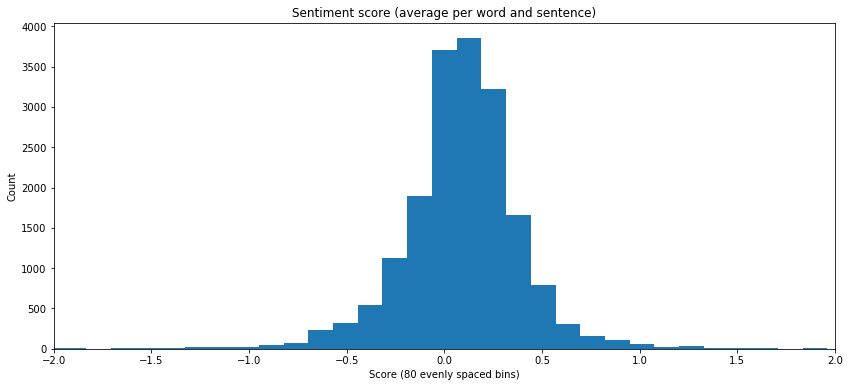

max: 5.9375
min: -5.83333333333


In [15]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt

data = pd.Series(sentence_sentiment)
bins = np.linspace(math.ceil(min(data)), 
                   math.floor(max(data)),
                   80) # fixed number of bins
plt.figure(1, figsize=(14, 6))
plt.xlim(-2, 2)
#plt.xlim([min(data), max(data)])
plt.hist(data, bins=bins, alpha=1)
plt.title('Sentiment score (average per word and sentence)')
plt.xlabel('Score (80 evenly spaced bins)')
plt.ylabel('Count')
plt.show()
print("max: " + str(max(data)))
print("min: " + str(min(data)))

In [25]:
# Dumps results
dump(sentence_sentiment, "../dumps/sentiment_per_sentence.pkl")

#### Prepare data for merge

In [32]:
# loads DF with entities
df = load('../dumps/df_sel_entities.pkl')
print(type(df))
print(df.shape)
df.head(2)

<class 'pandas.core.frame.DataFrame'>
(18340, 17)


,Unnamed: 0,index,Sound Bite Text,Title,Post Type,Media Type,Source Type,Domain,Richness,Interests,Positive Objects,Negative Objects,Topic_top,Topic_id,Topic_raw,Topic_name,entities
0,0,0,"Mobile & Apps FILE - In this July 9, 2015, fil...",PepsiCo beats 3Q profit forecasts,Original,No Media,Blogs,mercedsunstar.com,1.0,NaN,NaN,NaN,6,6,6:0.987499999969,terms14.png,elise amendola_file ap_the associated press_mo...
1,1,1,"Mobile & Apps FILE - In this July 9, 2015, fil...",PepsiCo beats 3Q profit forecasts,Original,No Media,Blogs,mercedsunstar.com,1.0,NaN,NaN,NaN,6,6,6:0.98908045974,terms14.png,elise amendola_file ap_the associated press_mo...


In [28]:
# loads sentiments scores created
sentiment_score=load('../dumps/sentiment_per_sentence.pkl')
print(type(sentiment_score))
print(len(sentiment_score))
print(sentiment_score[:5])

<class 'list'>
18340
[0.14724323583019233, 0.1373463151559952, 0.3155255039713011, 0.5319999294184077, 0.22614322150128127]


#### Merge new information

In [29]:
df = df.assign(Sentiment = sentiment_score)
print(df.shape)
df.head(2)

(18340, 18)


,Unnamed: 0,index,Sound Bite Text,Title,Post Type,Media Type,Source Type,Domain,Richness,Interests,Positive Objects,Negative Objects,Topic_top,Topic_id,Topic_raw,Topic_name,entities,Sentiment
0,0,0,"Mobile & Apps FILE - In this July 9, 2015, fil...",PepsiCo beats 3Q profit forecasts,Original,No Media,Blogs,mercedsunstar.com,1.0,NaN,NaN,NaN,6,6,6:0.987499999969,terms14.png,elise amendola_file ap_the associated press_mo...,0.147243
1,1,1,"Mobile & Apps FILE - In this July 9, 2015, fil...",PepsiCo beats 3Q profit forecasts,Original,No Media,Blogs,mercedsunstar.com,1.0,NaN,NaN,NaN,6,6,6:0.98908045974,terms14.png,elise amendola_file ap_the associated press_mo...,0.137346


#### Dumps DF merged

In [30]:
dump(df, "../dumps/df_sel_entities_sentiment.pkl")